In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import shap
from lifelines import KaplanMeierFitter, CoxPHFitter

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)


In [37]:
df = pd.read_csv('./data/archive/Churn_Modelling.csv')
print("="*80)
print("DATASET OVERVIEW")
print("="*80)

print(f"\nDataset Shape: {df.shape}")
print(f"Total Customers: {len(df):,}")

print("\n" + "="*80)
print("CHURN DISTRIBUTION")
print("="*80)

churn_counts = df['Exited'].value_counts()
churn_rate = df['Exited'].mean()

print(f"\nRetained Customers: {churn_counts[0]:,} ({(1-churn_rate)*100:.2f}%)")
print(f"Churned Customers: {churn_counts[1]:,} ({churn_rate*100:.2f}%)")
print(f"\nChurn Rate: {churn_rate*100:.2f}%")

print("\n" + "="*80)
print("FIRST 5 ROWS")
print("="*80)
print(df.head())

print("\n" + "="*80)
print("DATA TYPES & INFO")
print("="*80)
print(df.info())

print("\n" + "="*80)
print("MISSING VALUES")
print("="*80)
missing = df.isnull().sum()
print(missing[missing > 0])
if missing.sum() == 0:
    print("✓ No missing values!")

print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)
print(df.describe())

print(f"\nDuplicate rows: {df.duplicated().sum()}")


DATASET OVERVIEW

Dataset Shape: (10000, 14)
Total Customers: 10,000

CHURN DISTRIBUTION

Retained Customers: 7,963 (79.63%)
Churned Customers: 2,037 (20.37%)

Churn Rate: 20.37%

FIRST 5 ROWS
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82            

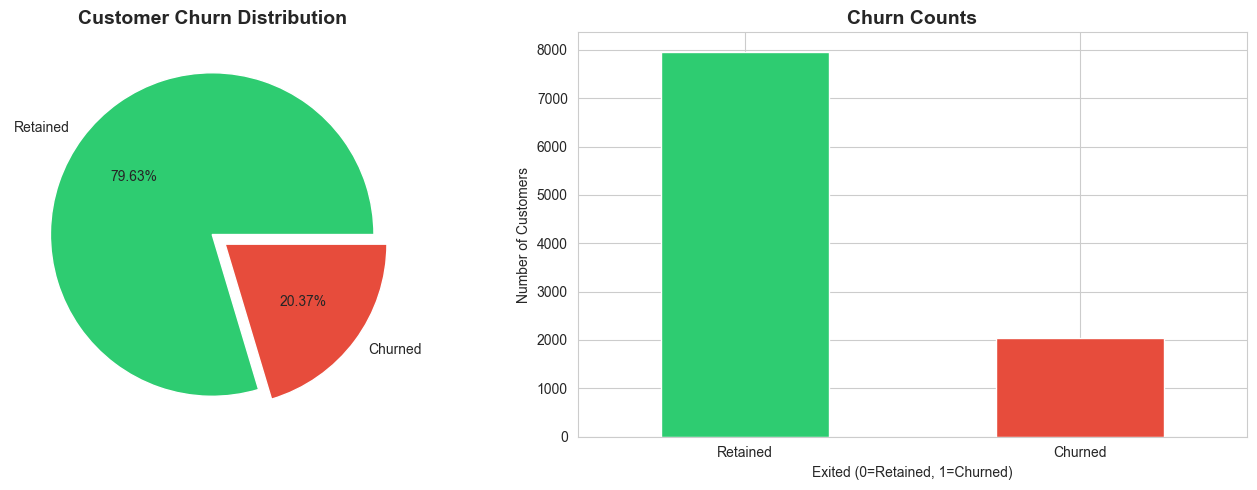

✓ Dataset is imbalanced
  (Churn rate: 20.37%)


In [38]:
# Churn distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
churn_counts.plot(kind='pie', ax=axes[0], autopct='%1.2f%%', 
                  colors=['#2ecc71', '#e74c3c'], labels=['Retained', 'Churned'],
                  explode=(0, 0.1))
axes[0].set_title('Customer Churn Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('')

# Bar chart
churn_counts.plot(kind='bar', ax=axes[1], color=['#2ecc71', '#e74c3c'])
axes[1].set_title('Churn Counts', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Exited (0=Retained, 1=Churned)')
axes[1].set_ylabel('Number of Customers')
axes[1].set_xticklabels(['Retained', 'Churned'], rotation=0)

plt.tight_layout()
plt.show()

print(f"✓ Dataset is {'balanced' if 0.3 <= churn_rate <= 0.7 else 'imbalanced'}")
print(f"  (Churn rate: {churn_rate*100:.2f}%)")



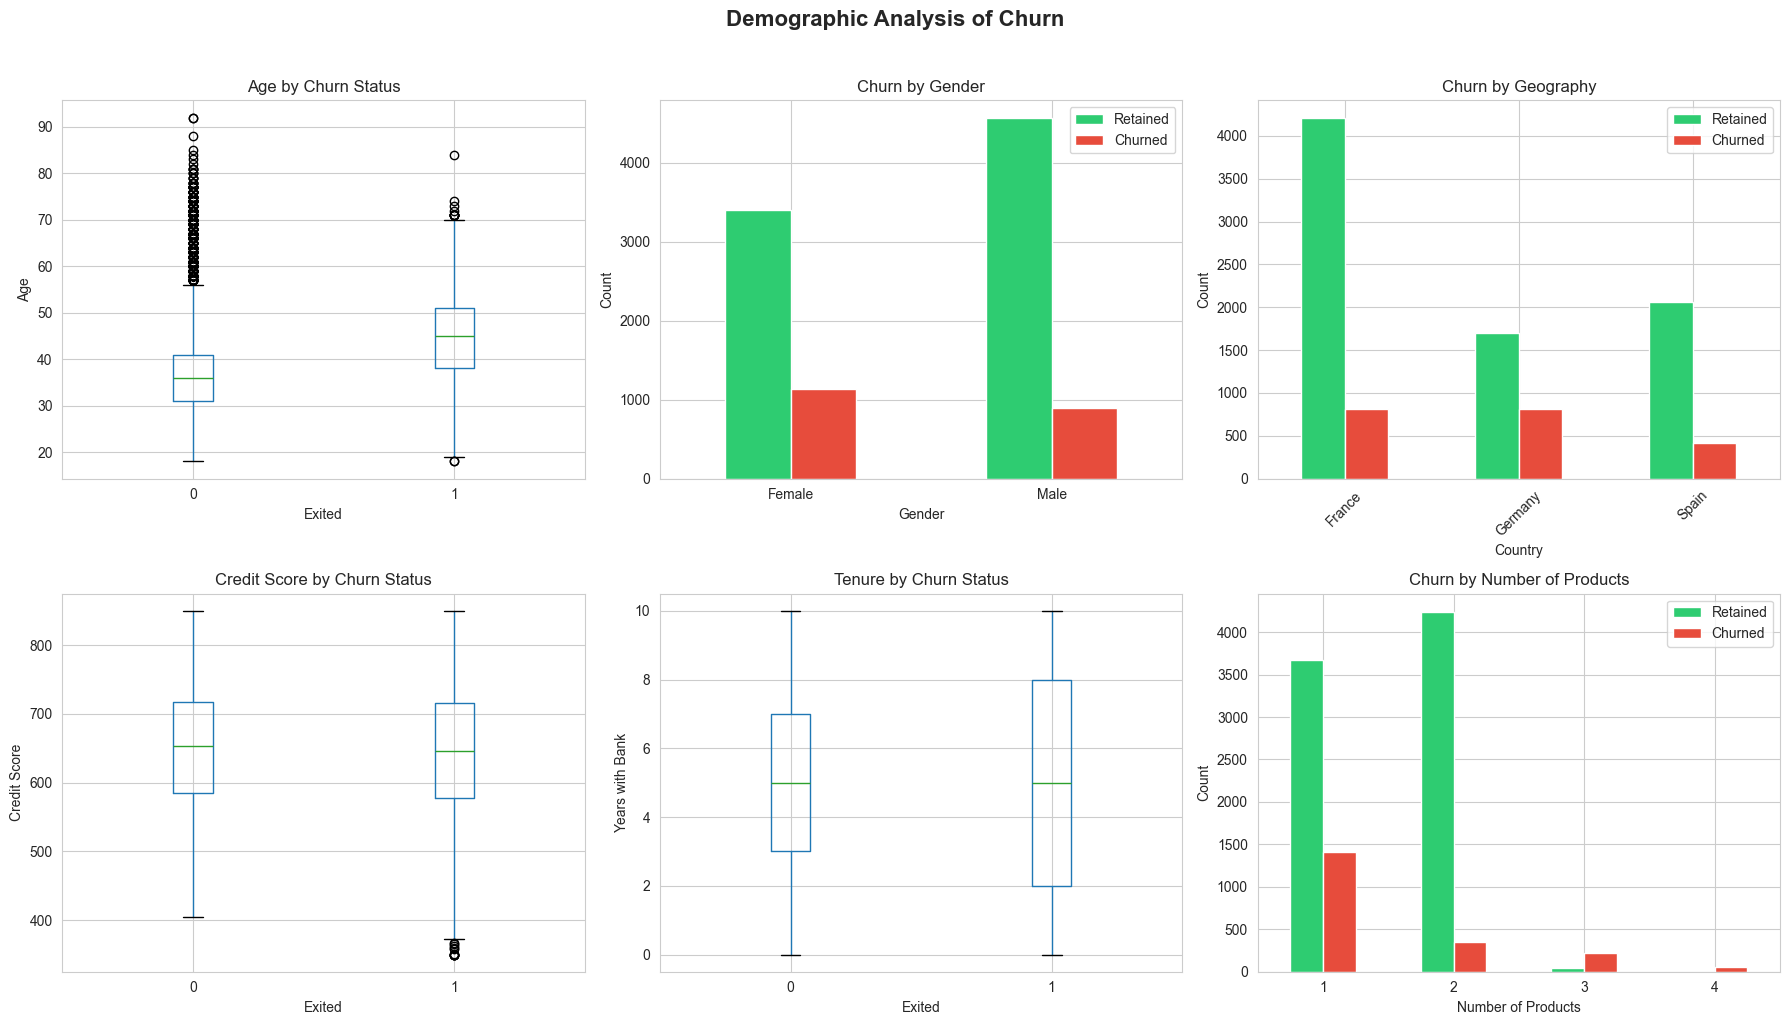

In [39]:
# Churn by demographics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Age distribution
df.boxplot(column='Age', by='Exited', ax=axes[0, 0])
axes[0, 0].set_title('Age by Churn Status')
axes[0, 0].set_xlabel('Exited')
axes[0, 0].set_ylabel('Age')

# Gender
gender_churn = df.groupby(['Gender', 'Exited']).size().unstack()
gender_churn.plot(kind='bar', ax=axes[0, 1], color=['#2ecc71', '#e74c3c'])
axes[0, 1].set_title('Churn by Gender')
axes[0, 1].set_xlabel('Gender')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(['Retained', 'Churned'])
axes[0, 1].tick_params(axis='x', rotation=0)

# Geography
geo_churn = df.groupby(['Geography', 'Exited']).size().unstack()
geo_churn.plot(kind='bar', ax=axes[0, 2], color=['#2ecc71', '#e74c3c'])
axes[0, 2].set_title('Churn by Geography')
axes[0, 2].set_xlabel('Country')
axes[0, 2].set_ylabel('Count')
axes[0, 2].legend(['Retained', 'Churned'])
axes[0, 2].tick_params(axis='x', rotation=45)

# Credit Score
df.boxplot(column='CreditScore', by='Exited', ax=axes[1, 0])
axes[1, 0].set_title('Credit Score by Churn Status')
axes[1, 0].set_xlabel('Exited')
axes[1, 0].set_ylabel('Credit Score')

# Tenure
df.boxplot(column='Tenure', by='Exited', ax=axes[1, 1])
axes[1, 1].set_title('Tenure by Churn Status')
axes[1, 1].set_xlabel('Exited')
axes[1, 1].set_ylabel('Years with Bank')

# Number of Products
products_churn = df.groupby(['NumOfProducts', 'Exited']).size().unstack()
products_churn.plot(kind='bar', ax=axes[1, 2], color=['#2ecc71', '#e74c3c'])
axes[1, 2].set_title('Churn by Number of Products')
axes[1, 2].set_xlabel('Number of Products')
axes[1, 2].set_ylabel('Count')
axes[1, 2].legend(['Retained', 'Churned'])
axes[1, 2].tick_params(axis='x', rotation=0)

plt.suptitle('Demographic Analysis of Churn', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [40]:
# Calculate churn rates by category
print("="*80)
print("CHURN RATES BY CATEGORY")
print("="*80)

print("\nBy Gender:")
print(df.groupby('Gender')['Exited'].agg(['mean', 'count']))

print("\nBy Geography:")
print(df.groupby('Geography')['Exited'].agg(['mean', 'count']))

print("\nBy Number of Products:")
print(df.groupby('NumOfProducts')['Exited'].agg(['mean', 'count']))

print("\nBy Active Membership:")
print(df.groupby('IsActiveMember')['Exited'].agg(['mean', 'count']))


CHURN RATES BY CATEGORY

By Gender:
            mean  count
Gender                 
Female  0.250715   4543
Male    0.164559   5457

By Geography:
               mean  count
Geography                 
France     0.161548   5014
Germany    0.324432   2509
Spain      0.166734   2477

By Number of Products:
                   mean  count
NumOfProducts                 
1              0.277144   5084
2              0.075817   4590
3              0.827068    266
4              1.000000     60

By Active Membership:
                    mean  count
IsActiveMember                 
0               0.268509   4849
1               0.142691   5151


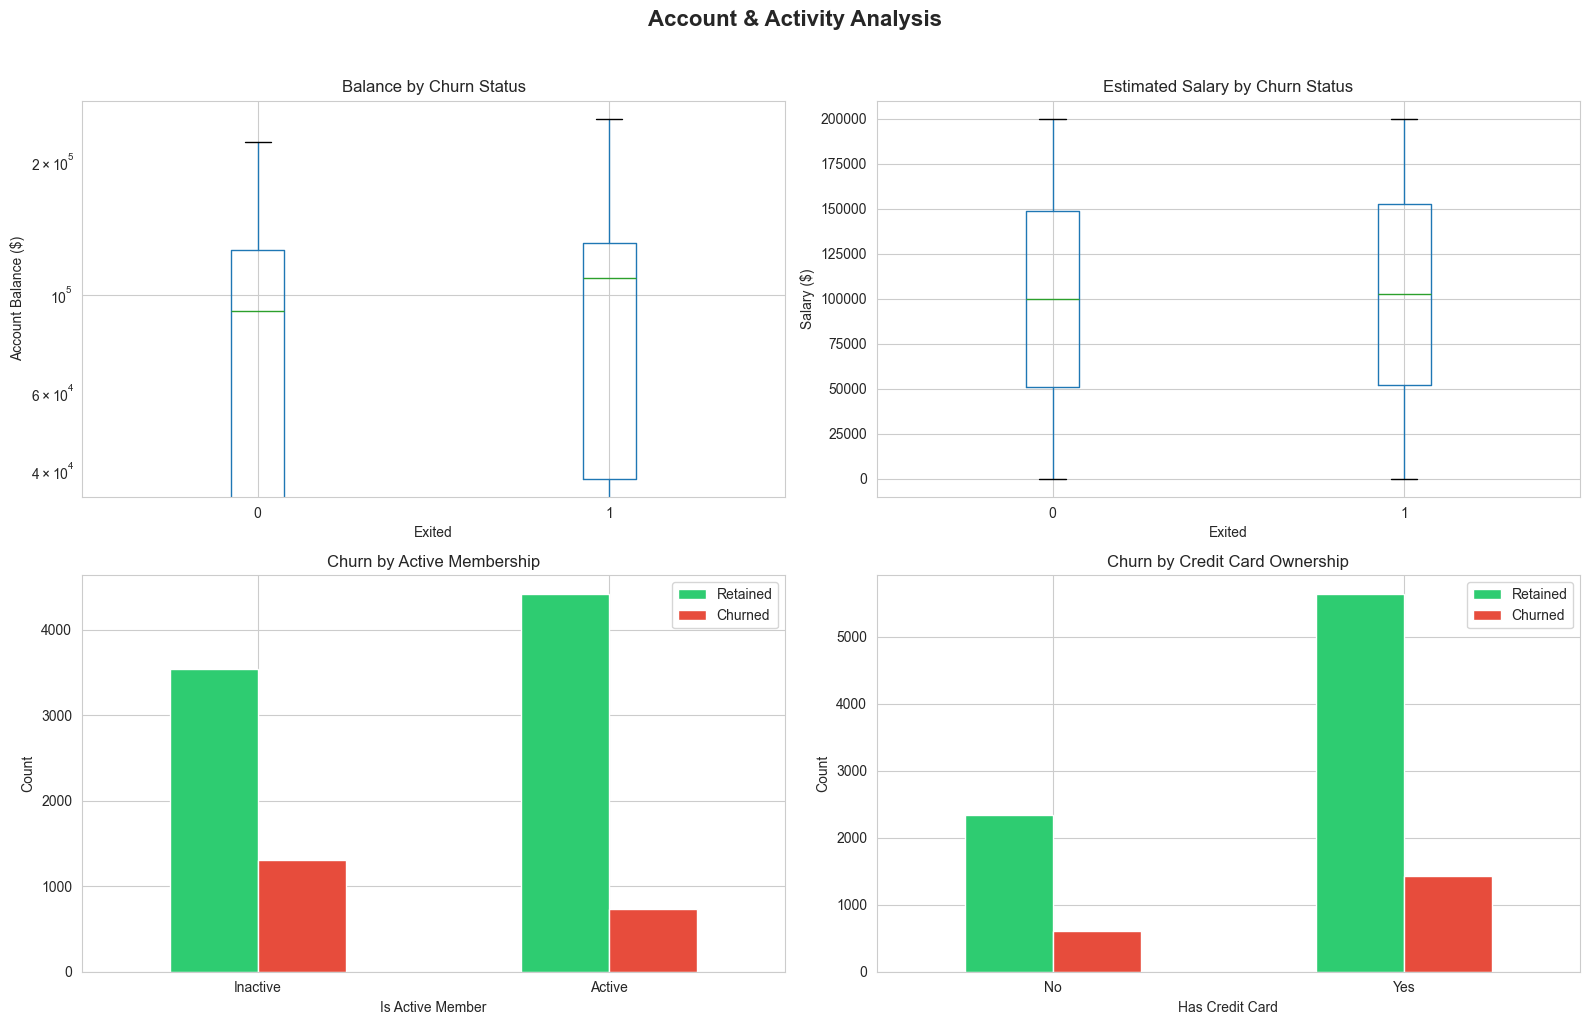

In [41]:
# Account metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Balance distribution
df.boxplot(column='Balance', by='Exited', ax=axes[0, 0])
axes[0, 0].set_title('Balance by Churn Status')
axes[0, 0].set_xlabel('Exited')
axes[0, 0].set_ylabel('Account Balance ($)')
axes[0, 0].set_yscale('log')

# Salary distribution
df.boxplot(column='EstimatedSalary', by='Exited', ax=axes[0, 1])
axes[0, 1].set_title('Estimated Salary by Churn Status')
axes[0, 1].set_xlabel('Exited')
axes[0, 1].set_ylabel('Salary ($)')

# Active membership
active_churn = df.groupby(['IsActiveMember', 'Exited']).size().unstack()
active_churn.plot(kind='bar', ax=axes[1, 0], color=['#2ecc71', '#e74c3c'])
axes[1, 0].set_title('Churn by Active Membership')
axes[1, 0].set_xlabel('Is Active Member')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend(['Retained', 'Churned'])
axes[1, 0].set_xticklabels(['Inactive', 'Active'], rotation=0)

# Credit card ownership
cc_churn = df.groupby(['HasCrCard', 'Exited']).size().unstack()
cc_churn.plot(kind='bar', ax=axes[1, 1], color=['#2ecc71', '#e74c3c'])
axes[1, 1].set_title('Churn by Credit Card Ownership')
axes[1, 1].set_xlabel('Has Credit Card')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend(['Retained', 'Churned'])
axes[1, 1].set_xticklabels(['No', 'Yes'], rotation=0)

plt.suptitle('Account & Activity Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()



In [42]:
# Key metrics
print("="*80)
print("KEY INSIGHTS")
print("="*80)

print("\nActive vs Inactive Members:")
active_stats = df.groupby('IsActiveMember')['Exited'].mean()
print(f"  Inactive churn rate: {active_stats[0]*100:.2f}%")
print(f"  Active churn rate: {active_stats[1]*100:.2f}%")
print(f"  Difference: {(active_stats[0] - active_stats[1])*100:.2f} percentage points")

print("\nBy Number of Products:")
products_stats = df.groupby('NumOfProducts')['Exited'].mean()
for n_products, churn_rate in products_stats.items():
    print(f"  {n_products} product(s): {churn_rate*100:.2f}% churn rate")


KEY INSIGHTS

Active vs Inactive Members:
  Inactive churn rate: 26.85%
  Active churn rate: 14.27%
  Difference: 12.58 percentage points

By Number of Products:
  1 product(s): 27.71% churn rate
  2 product(s): 7.58% churn rate
  3 product(s): 82.71% churn rate
  4 product(s): 100.00% churn rate


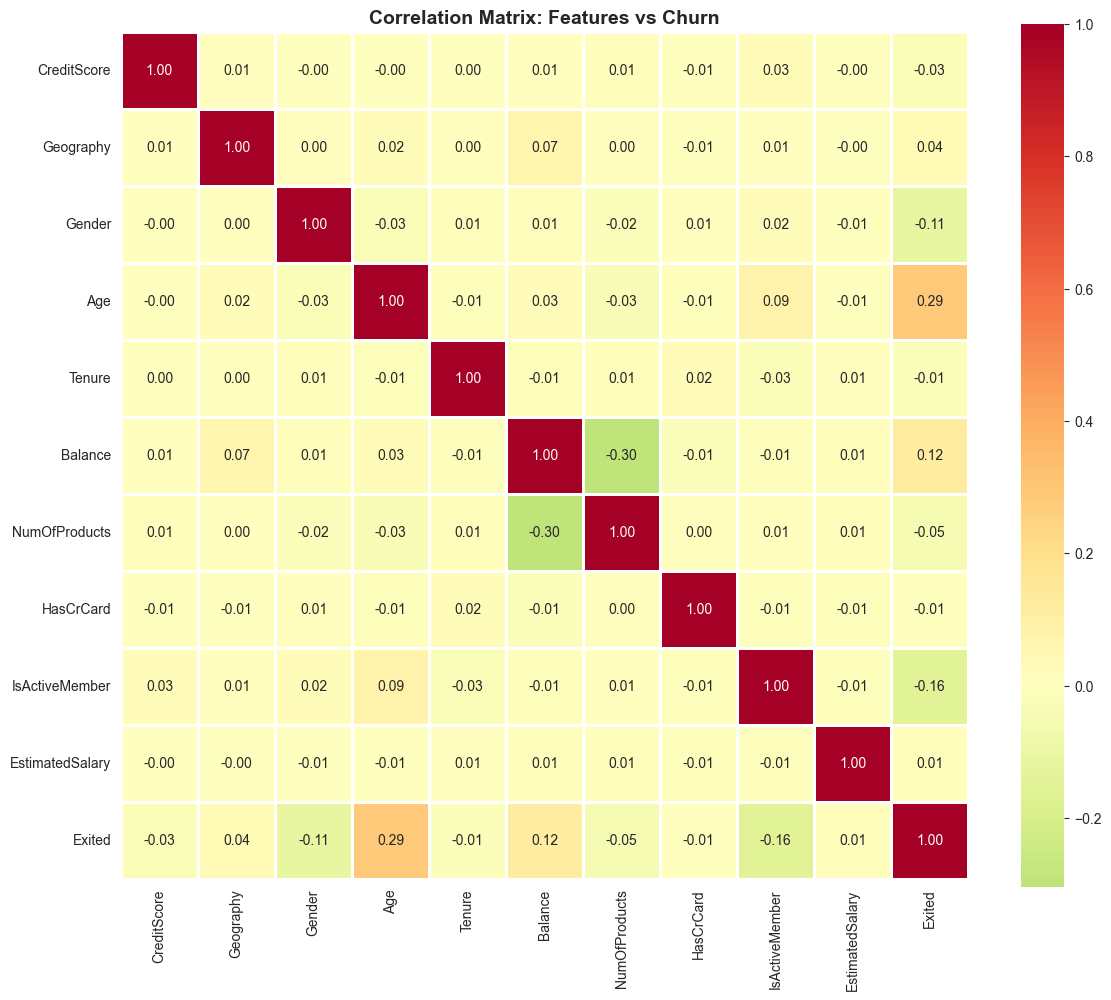

In [43]:
# Correlation matrix
# First encode categorical variables
df_encoded = df.copy()
df_encoded['Gender'] = LabelEncoder().fit_transform(df['Gender'])
df_encoded['Geography'] = LabelEncoder().fit_transform(df['Geography'])

# Select numeric columns
numeric_cols = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 
                'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
                'EstimatedSalary', 'Exited']

corr_matrix = df_encoded[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Matrix: Features vs Churn', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [44]:
# Top correlations with Exited
print("="*80)
print("FEATURES MOST CORRELATED WITH CHURN")
print("="*80)
churn_corr = corr_matrix['Exited'].sort_values(ascending=False)
print(churn_corr)

print("\n Key Findings:")
print(f"  • Age has {churn_corr['Age']:.3f} correlation with churn")
print(f"  • IsActiveMember has {churn_corr['IsActiveMember']:.3f} correlation")
print(f"  • Geography has {churn_corr['Geography']:.3f} correlation")


FEATURES MOST CORRELATED WITH CHURN
Exited             1.000000
Age                0.285323
Balance            0.118533
Geography          0.035943
EstimatedSalary    0.012097
HasCrCard         -0.007138
Tenure            -0.014001
CreditScore       -0.027094
NumOfProducts     -0.047820
Gender            -0.106512
IsActiveMember    -0.156128
Name: Exited, dtype: float64

 Key Findings:
  • Age has 0.285 correlation with churn
  • IsActiveMember has -0.156 correlation
  • Geography has 0.036 correlation


In [45]:
#5. Feature Engineering 
print("="*80)
print("FEATURE ENGINEERING")
print("="*80)

# 1. Age groups
df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, 100], 
                        labels=['<30', '30-40', '40-50', '50-60', '60+'])

# 2. Balance categories
df['BalanceCategory'] = pd.cut(df['Balance'], 
                               bins=[-1, 0, 50000, 100000, 250000], 
                               labels=['Zero', 'Low', 'Medium', 'High'])

# 3. Salary categories
df['SalaryCategory'] = pd.cut(df['EstimatedSalary'], 
                              bins=[0, 50000, 100000, 150000, 200000], 
                              labels=['Low', 'Medium', 'High', 'Very High'])

# 4. Credit score categories
df['CreditScoreCategory'] = pd.cut(df['CreditScore'], 
                                   bins=[0, 580, 670, 740, 800, 900], 
                                   labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])

# 5. Tenure groups
df['TenureGroup'] = pd.cut(df['Tenure'], bins=[0, 2, 5, 8, 11], 
                           labels=['New (0-2yr)', 'Growing (3-5yr)', 
                                   'Established (6-8yr)', 'Loyal (9-10yr)'])

# 6. Product density (products per tenure year)
df['ProductDensity'] = df['NumOfProducts'] / (df['Tenure'] + 1)  # +1 to avoid division by zero

# 7. Balance to Salary ratio
df['BalanceToSalary'] = df['Balance'] / (df['EstimatedSalary'] + 1)

# 8. Is high-value customer?
df['IsHighValue'] = ((df['Balance'] > 100000) | (df['EstimatedSalary'] > 150000)).astype(int)

# 9. Engagement score (composite)
df['EngagementScore'] = (
    df['IsActiveMember'] * 3 + 
    df['HasCrCard'] * 2 + 
    (df['NumOfProducts'] - 1)  # Normalized
).clip(0, 10)

# 10. Risk flag
df['RiskFlag'] = (
    (df['Age'] > 45) & 
    (df['IsActiveMember'] == 0) & 
    (df['NumOfProducts'] <= 1)
).astype(int)

print("\nNew Features Sample:")
print(df[['CustomerId', 'AgeGroup', 'BalanceCategory', 'EngagementScore', 
          'RiskFlag', 'Exited']].head(10))

FEATURE ENGINEERING

New Features Sample:
   CustomerId AgeGroup BalanceCategory  EngagementScore  RiskFlag  Exited
0    15634602    40-50            Zero                5         0       1
1    15647311    40-50          Medium                3         0       0
2    15619304    40-50            High                4         0       1
3    15701354    30-40            Zero                1         0       0
4    15737888    40-50            High                5         0       0
5    15574012    40-50            High                3         0       1
6    15592531    40-50            Zero                6         0       0
7    15656148      <30            High                5         0       1
8    15792365    40-50            High                4         0       0
9    15592389      <30            High                5         0       0


In [46]:
# Analyze new features
print("\n" + "="*80)
print("CHURN RATE BY ENGINEERED FEATURES")
print("="*80)

print("\nBy Age Group:")
print(df.groupby('AgeGroup')['Exited'].agg(['mean', 'count']))

print("\nBy Balance Category:")
print(df.groupby('BalanceCategory')['Exited'].agg(['mean', 'count']))

print("\nBy Tenure Group:")
print(df.groupby('TenureGroup')['Exited'].agg(['mean', 'count']))

print("\nBy Engagement Score:")
print(df.groupby('EngagementScore')['Exited'].agg(['mean', 'count']).head(10))



CHURN RATE BY ENGINEERED FEATURES

By Age Group:
              mean  count
AgeGroup                 
<30       0.075203   1968
30-40     0.120872   4451
40-50     0.339655   2320
50-60     0.562108    797
60+       0.247845    464

By Balance Category:
                     mean  count
BalanceCategory                 
Zero             0.138236   3617
Low              0.346667     75
Medium           0.198807   1509
High             0.252188   4798

By Tenure Group:
                         mean  count
TenureGroup                         
New (0-2yr)          0.207873   2083
Growing (3-5yr)      0.207641   3010
Established (6-8yr)  0.188742   3020
Loyal (9-10yr)       0.213026   1474

By Engagement Score:
                     mean  count
EngagementScore                 
0                0.345404    718
1                0.104265    633
2                0.386659   1844
3                0.140815   2308
4                0.174970    823
5                0.198690   1832
6                0.057

In [47]:
#6. RFM Segmentation 
print("="*80)
print("RFM SEGMENTATION")
print("="*80)

# RFM Components:
# Recency: How recently did they transact? (Use Tenure as proxy - lower = more recent join)
# Frequency: How often do they transact? (Use IsActiveMember + NumOfProducts)
# Monetary: How much do they spend/hold? (Use Balance + EstimatedSalary)

# Recency Score (inverse of tenure - recent joiners get higher scores)
df['R_Score'] = pd.qcut(10 - df['Tenure'], q=4, labels=[1, 2, 3, 4], duplicates='drop')

# Frequency Score (based on activity + products)
df['FrequencyMetric'] = df['IsActiveMember'] * 5 + df['NumOfProducts'] * 2
df['F_Score'] = pd.qcut(df['FrequencyMetric'], q=5, labels=[1, 2, 3, 4], duplicates='drop')

# Monetary Score (based on balance + salary)
df['MonetaryMetric'] = df['Balance'] + df['EstimatedSalary'] * 0.1
df['M_Score'] = pd.qcut(df['MonetaryMetric'], q=4, labels=[1, 2, 3, 4], duplicates='drop')

# Convert to numeric
df['R_Score'] = df['R_Score'].astype(int)
df['F_Score'] = df['F_Score'].astype(int)
df['M_Score'] = df['M_Score'].astype(int)

# Create RFM segment
df['RFM_Segment'] = (
    df['R_Score'].astype(str) + 
    df['F_Score'].astype(str) + 
    df['M_Score'].astype(str)
)

# Create simplified segments
def rfm_category(row):
    r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
    rfm_score = r + f + m
    
    if rfm_score >= 10:
        return 'Champions'
    elif rfm_score >= 8:
        return 'Loyal Customers'
    elif rfm_score >= 6:
        return 'Potential Loyalists'
    elif rfm_score >= 5:
        return 'At Risk'
    else:
        return 'Lost Customers'

df['RFM_Category'] = df.apply(rfm_category, axis=1)

print("\nRFM Segment Distribution:")
print(df['RFM_Category'].value_counts())

print("\nChurn Rate by RFM Category:")
rfm_churn = df.groupby('RFM_Category')['Exited'].agg(['mean', 'count', 'sum'])
rfm_churn.columns = ['Churn_Rate', 'Total_Customers', 'Churned_Count']
rfm_churn = rfm_churn.sort_values('Churn_Rate', ascending=False)
print(rfm_churn)


RFM SEGMENTATION

RFM Segment Distribution:
RFM_Category
Potential Loyalists    3999
Loyal Customers        2755
At Risk                1492
Lost Customers         1178
Champions               576
Name: count, dtype: int64

Churn Rate by RFM Category:
                     Churn_Rate  Total_Customers  Churned_Count
RFM_Category                                                   
Loyal Customers        0.217060             2755            598
Potential Loyalists    0.207052             3999            828
Champions              0.196181              576            113
At Risk                0.195040             1492            291
Lost Customers         0.175722             1178            207


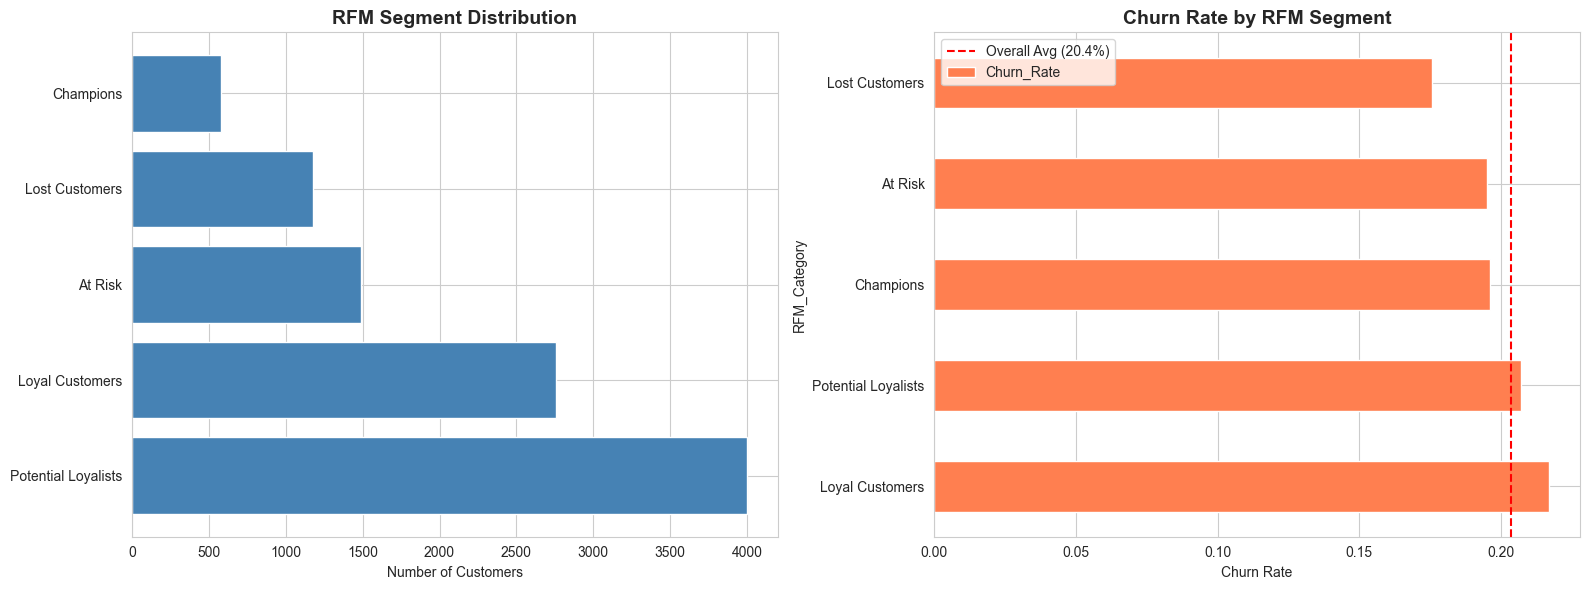


Key Finding: 'Loyal Customers' segment has highest churn rate!


In [48]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# RFM distribution
rfm_dist = df['RFM_Category'].value_counts()
axes[0].barh(rfm_dist.index, rfm_dist.values, color='steelblue')
axes[0].set_title('RFM Segment Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Customers')

# Churn by RFM
rfm_churn['Churn_Rate'].plot(kind='barh', ax=axes[1], color='coral')
axes[1].set_title('Churn Rate by RFM Segment', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Churn Rate')
axes[1].axvline(x=df['Exited'].mean(), color='red', linestyle='--', 
                label=f'Overall Avg ({df["Exited"].mean()*100:.1f}%)')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nKey Finding: '{rfm_churn.index[0]}' segment has highest churn rate!")

In [49]:
#7. Churn Prediction Models
print("="*80)
print("DATA PREPARATION FOR MODELING")
print("="*80)

# Drop unnecessary columns
cols_to_drop = ['RowNumber', 'CustomerId', 'Surname', 'AgeGroup', 'BalanceCategory', 
                'SalaryCategory', 'CreditScoreCategory', 'TenureGroup', 'RFM_Segment', 
                'RFM_Category', 'FrequencyMetric', 'MonetaryMetric']

# Create feature matrix
X = df.drop(cols_to_drop + ['Exited'], axis=1)

# Encode categorical variables
categorical_cols = ['Geography', 'Gender']
for col in categorical_cols:
    X[col] = LabelEncoder().fit_transform(X[col])

y = df['Exited']

print(f"Feature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining Set: {len(X_train):,} samples")
print(f"Test Set: {len(X_test):,} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n Data prepared for modeling")


DATA PREPARATION FOR MODELING
Feature Matrix Shape: (10000, 18)
Target Vector Shape: (10000,)

Features: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'ProductDensity', 'BalanceToSalary', 'IsHighValue', 'EngagementScore', 'RiskFlag', 'R_Score', 'F_Score', 'M_Score']

Training Set: 8,000 samples
Test Set: 2,000 samples

 Data prepared for modeling


In [50]:
print("="*80)
print("MODEL 1: LOGISTIC REGRESSION (BASELINE)")
print("="*80)

# Train model
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr.predict(X_test_scaled)
y_pred_proba_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Retained', 'Churned']))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")


MODEL 1: LOGISTIC REGRESSION (BASELINE)

Classification Report:
              precision    recall  f1-score   support

    Retained       0.84      0.98      0.90      1593
     Churned       0.74      0.26      0.39       407

    accuracy                           0.83      2000
   macro avg       0.79      0.62      0.65      2000
weighted avg       0.82      0.83      0.80      2000


ROC-AUC Score: 0.7824


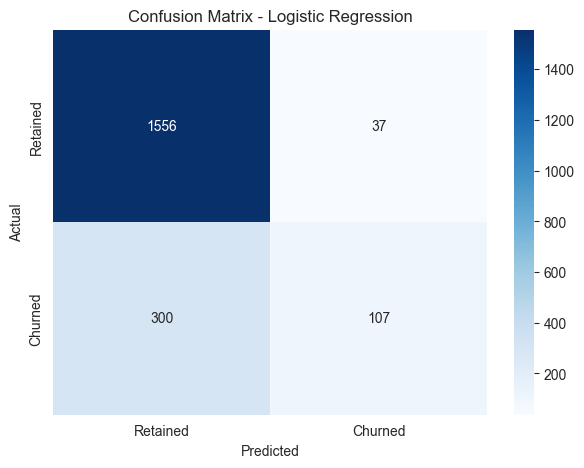

In [51]:
# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [52]:
# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_[0]
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_lr.head(10))



Top 10 Most Important Features:
            Feature  Coefficient
16          F_Score     0.926852
8    IsActiveMember    -0.718301
3               Age     0.572697
13  EngagementScore    -0.514743
5           Balance     0.414613
14         RiskFlag     0.383854
2            Gender    -0.269404
17          M_Score    -0.233973
7         HasCrCard     0.211501
12      IsHighValue     0.179422


MODEL 2: RANDOM FOREST

Classification Report:
              precision    recall  f1-score   support

    Retained       0.86      0.98      0.92      1593
     Churned       0.83      0.40      0.54       407

    accuracy                           0.86      2000
   macro avg       0.85      0.69      0.73      2000
weighted avg       0.86      0.86      0.84      2000


ROC-AUC Score: 0.8537


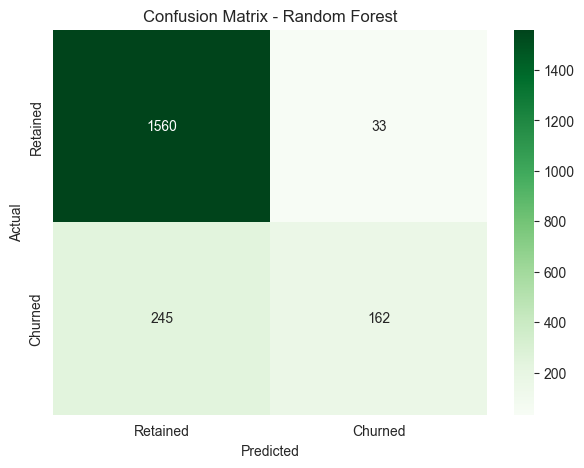

In [53]:
#Random Forest
print("="*80)
print("MODEL 2: RANDOM FOREST")
print("="*80)

# Train model
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Retained', 'Churned']))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



Top 10 Most Important Features:
            Feature  Importance
3               Age    0.233310
6     NumOfProducts    0.156608
14         RiskFlag    0.131583
13  EngagementScore    0.063297
16          F_Score    0.055536
5           Balance    0.054281
0       CreditScore    0.050333
9   EstimatedSalary    0.048586
11  BalanceToSalary    0.047893
1         Geography    0.031929


<Figure size 1000x600 with 0 Axes>

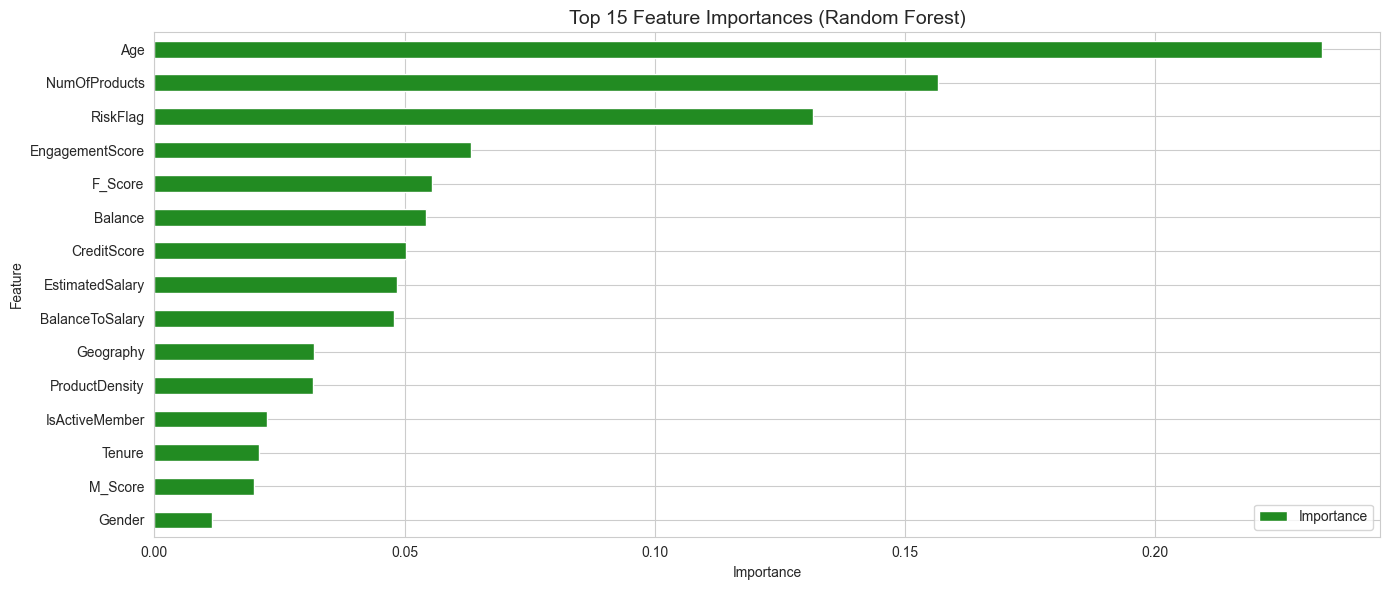

In [54]:

# Feature importance
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_rf.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
feature_importance_rf.head(15).plot(x='Feature', y='Importance', kind='barh', color='forestgreen')
plt.title('Top 15 Feature Importances (Random Forest)', fontsize=14)
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [55]:
# Gradient Boosting Classifier
print("="*80)
print("MODEL 3: GRADIENT BOOSTING")
print("="*80)

# Train model
gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gb.fit(X_train, y_train)

# Predictions
y_pred_gb = gb.predict(X_test)
y_pred_proba_gb = gb.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb, target_names=['Retained', 'Churned']))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_gb):.4f}")


MODEL 3: GRADIENT BOOSTING

Classification Report:
              precision    recall  f1-score   support

    Retained       0.87      0.96      0.92      1593
     Churned       0.76      0.44      0.56       407

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000


ROC-AUC Score: 0.8596


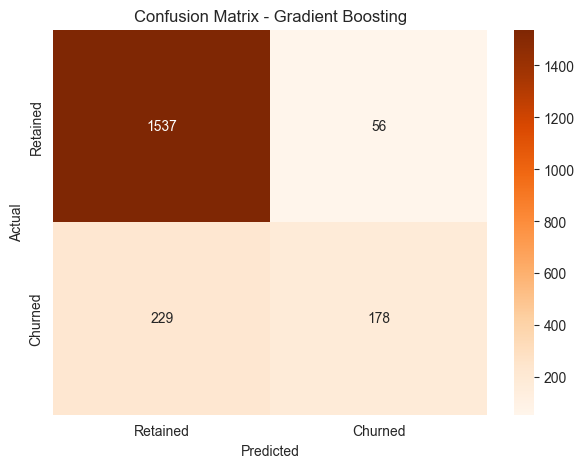

In [56]:
cm_gb = confusion_matrix(y_test, y_pred_gb)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
plt.title('Confusion Matrix - Gradient Boosting')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

MODEL 4: XGBOOST (BEST PERFORMANCE)

Classification Report:
              precision    recall  f1-score   support

    Retained       0.87      0.96      0.92      1593
     Churned       0.76      0.44      0.56       407

    accuracy                           0.86      2000
   macro avg       0.82      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000


ROC-AUC Score: 0.8528


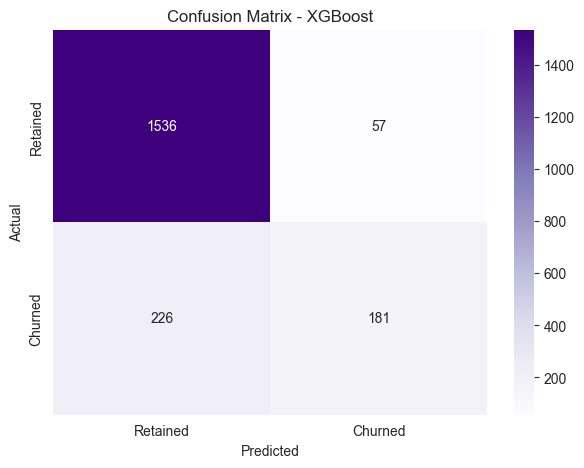

In [57]:
print("="*80)
print("MODEL 4: XGBOOST (BEST PERFORMANCE)")
print("="*80)

# Train model
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=['Retained', 'Churned']))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples', 
            xticklabels=['Retained', 'Churned'],
            yticklabels=['Retained', 'Churned'])
plt.title('Confusion Matrix - XGBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [58]:
print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)

# Store results
models_results = {
    'Logistic Regression': {
        'y_pred': y_pred_lr,
        'y_proba': y_pred_proba_lr,
        'model': lr
    },
    'Random Forest': {
        'y_pred': y_pred_rf,
        'y_proba': y_pred_proba_rf,
        'model': rf
    },
    'Gradient Boosting': {
        'y_pred': y_pred_gb,
        'y_proba': y_pred_proba_gb,
        'model': gb
    },
    'XGBoost': {
        'y_pred': y_pred_xgb,
        'y_proba': y_pred_proba_xgb,
        'model': xgb_model
    }
}

# Calculate metrics
comparison_df = []

for model_name, results in models_results.items():
    cm = confusion_matrix(y_test, results['y_pred'])
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    auc = roc_auc_score(y_test, results['y_proba'])
    
    comparison_df.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': auc
    })

comparison_df = pd.DataFrame(comparison_df).sort_values('ROC-AUC', ascending=False)

print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))


MODEL PERFORMANCE COMPARISON

Model Performance Comparison:
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
  Gradient Boosting    0.8575   0.760684 0.437346  0.555382 0.859645
      Random Forest    0.8610   0.830769 0.398034  0.538206 0.853687
            XGBoost    0.8585   0.760504 0.444717  0.561240 0.852790
Logistic Regression    0.8315   0.743056 0.262899  0.388385 0.782411


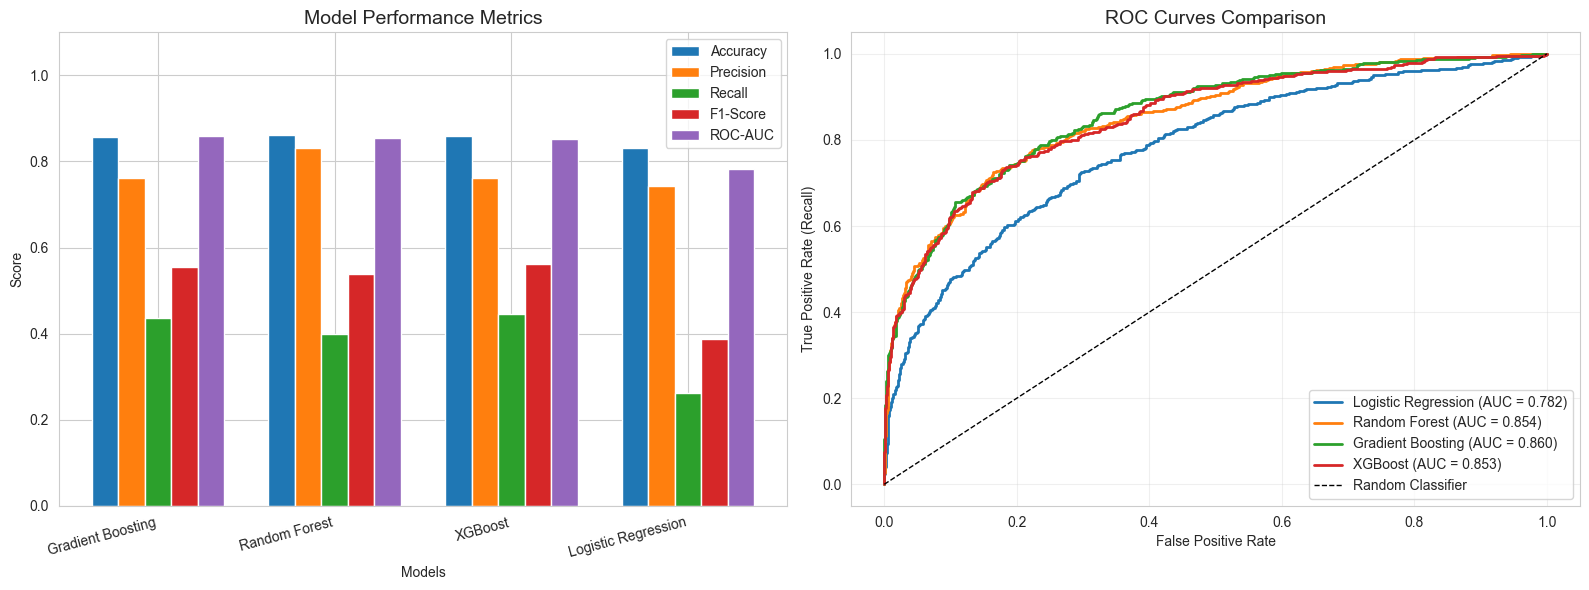

In [59]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(comparison_df))
width = 0.15

for i, metric in enumerate(metrics):
    axes[0].bar(x + i*width, comparison_df[metric], width, label=metric)

axes[0].set_xlabel('Models')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Metrics', fontsize=14)
axes[0].set_xticks(x + width * 2)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# ROC Curves
for model_name, results in models_results.items():
    fpr, tpr, _ = roc_curve(y_test, results['y_proba'])
    auc_score = roc_auc_score(y_test, results['y_proba'])
    axes[1].plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.3f})', linewidth=2)

axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate (Recall)')
axes[1].set_title('ROC Curves Comparison', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [60]:

# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_auc = comparison_df.iloc[0]['ROC-AUC']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name} (ROC-AUC: {best_auc:.4f})")
print(f"{'='*80}")



BEST MODEL: Gradient Boosting (ROC-AUC: 0.8596)


MODEL EXPLAINABILITY WITH SHAP


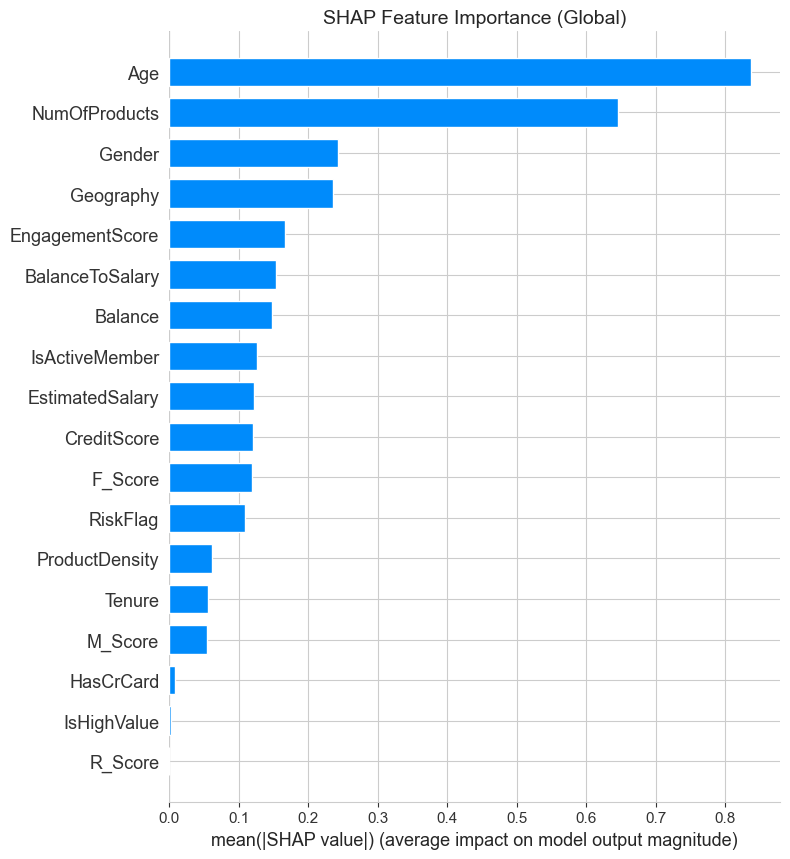

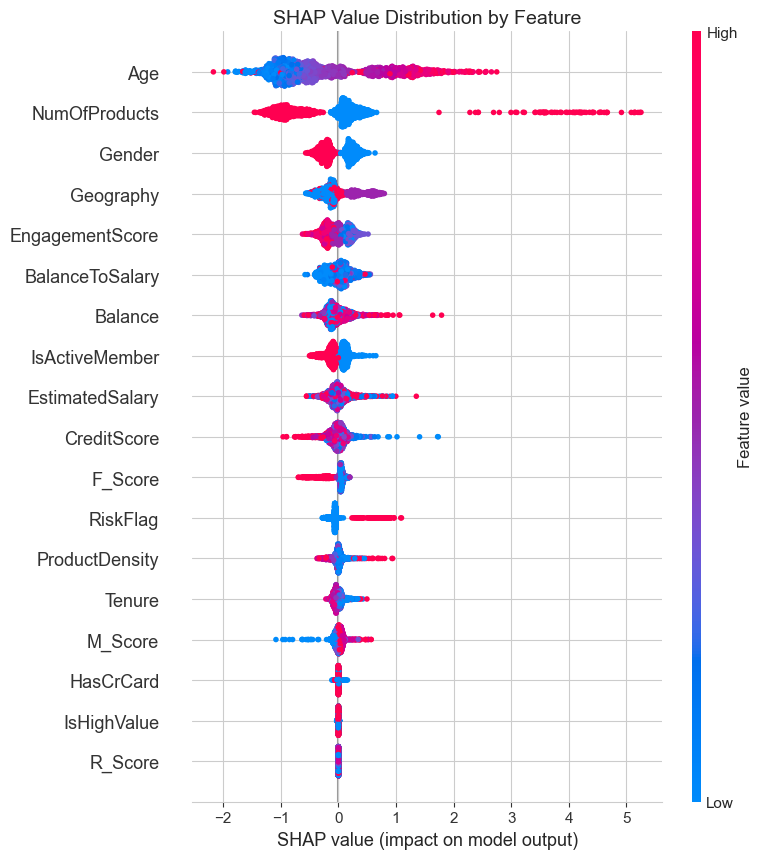


✓ SHAP analysis complete!

Key Insights from SHAP:
  • Red dots = high feature value
  • Blue dots = low feature value
  • X-axis = impact on prediction (positive = increase churn probability)


In [61]:
print("="*80)
print("MODEL EXPLAINABILITY WITH SHAP")
print("="*80)

# Use XGBoost model for SHAP (typically best performer)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Summary plot (global importance)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Global)', fontsize=14)
plt.tight_layout()
plt.show()

# Detailed summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title('SHAP Value Distribution by Feature', fontsize=14)
plt.tight_layout()
plt.show()

print("\n✓ SHAP analysis complete!")
print("\nKey Insights from SHAP:")
print("  • Red dots = high feature value")
print("  • Blue dots = low feature value")
print("  • X-axis = impact on prediction (positive = increase churn probability)")


In [63]:
print("="*80)
print("AT-RISK CUSTOMER IDENTIFICATION")
print("="*80)

# Predict churn probability for entire dataset
df['ChurnProbability'] = xgb_model.predict_proba(
    X.apply(lambda col: LabelEncoder().fit_transform(col) if col.dtype == 'object' else col)
)[:, 1]

# Segment by risk level
def risk_level(prob):
    if prob >= 0.7:
        return 'Critical Risk'
    elif prob >= 0.5:
        return 'High Risk'
    elif prob >= 0.3:
        return 'Medium Risk'
    else:
        return 'Low Risk'

df['RiskLevel'] = df['ChurnProbability'].apply(risk_level)

print("\nRisk Distribution:")
risk_dist = df['RiskLevel'].value_counts()
print(risk_dist)

# At-risk customers (not yet churned)
at_risk = df[(df['Exited'] == 0) & (df['RiskLevel'].isin(['High Risk', 'Critical Risk']))].copy()

print(f"\n {len(at_risk):,} customers at high/critical risk of churning")
print(f"   ({len(at_risk)/len(df[df['Exited']==0])*100:.2f}% of active customers)")

# Top 100 at-risk customers
top_at_risk = at_risk.nlargest(100, 'ChurnProbability')

print("\nTop 10 At-Risk Customers:")
print(top_at_risk[['CustomerId', 'Age', 'Geography', 'Balance', 'NumOfProducts', 
                   'IsActiveMember', 'RFM_Category', 'ChurnProbability']].head(10))


AT-RISK CUSTOMER IDENTIFICATION

Risk Distribution:
RiskLevel
Low Risk         7761
Medium Risk       945
Critical Risk     841
High Risk         453
Name: count, dtype: int64

 146 customers at high/critical risk of churning
   (1.83% of active customers)

Top 10 At-Risk Customers:
      CustomerId  Age Geography    Balance  NumOfProducts  IsActiveMember  \
7862    15811343   35   Germany  161591.11              3               1   
5158    15789582   55    France       0.00              1               0   
4137    15698732   51   Germany  104677.09              1               0   
2220    15806049   49   Germany  140510.89              1               0   
7803    15691504   52   Germany  124099.13              1               0   
8173    15568032   31   Germany  127320.36              3               0   
4886    15657468   53   Germany  123805.03              1               0   
1253    15699523   55   Germany  126817.65              2               0   
5132    15579826   66  

In [65]:
print("="*80)
print("RETENTION STRATEGY PLAYBOOK")
print("="*80)

# Define strategies by segment
def retention_strategy(row):
    rfm = row['RFM_Category']
    risk = row['RiskLevel']
    is_active = row['IsActiveMember']
    balance = row['Balance']
    products = row['NumOfProducts']
    
    # Strategy matrix
    if rfm == 'Champions':
        return {
            'Segment': 'Champions',
            'Priority': 'High',
            'Strategy': 'VIP Retention',
            'Actions': [
                'Assign dedicated relationship manager',
                'Offer premium benefits (travel lounge, concierge)',
                'Priority customer service hotline',
                'Exclusive investment opportunities'
            ],
            'Budget': '$500/customer',
            'Expected_Success': '95%'
        }
    
    elif rfm == 'Loyal Customers':
        return {
            'Segment': 'Loyal Customers',
            'Priority': 'High',
            'Strategy': 'Loyalty Rewards',
            'Actions': [
                'Cashback on transactions',
                'Fee waivers for 12 months',
                'Interest rate reduction on loans',
                'Referral bonuses'
            ],
            'Budget': '$200/customer',
            'Expected_Success': '85%'
        }
    
    elif is_active == 0:
        return {
            'Segment': 'Inactive Customers',
            'Priority': 'Critical',
            'Strategy': 'Re-engagement Campaign',
            'Actions': [
                'Personalized SMS: "We miss you!"',
                'Special reactivation bonus ($50)',
                'Waive monthly account fees',
                'Survey to understand why inactive'
            ],
            'Budget': '$100/customer',
            'Expected_Success': '60%'
        }
    
    elif products == 1:
        return {
            'Segment': 'Single Product Users',
            'Priority': 'Medium',
            'Strategy': 'Cross-Sell Campaign',
            'Actions': [
                'Offer second product with 6-month fee waiver',
                'Bundle discount (e.g., savings + credit card)',
                'Educational content on product benefits',
                'Limited-time signup bonus'
            ],
            'Budget': '$150/customer',
            'Expected_Success': '70%'
        }
    
    elif balance == 0:
        return {
            'Segment': 'Zero Balance',
            'Priority': 'Low',
            'Strategy': 'Account Usage Incentive',
            'Actions': [
                'Direct deposit bonus ($100)',
                'Reward for first 5 transactions',
                'Gamification (earn points)',
                'Financial wellness webinar'
            ],
            'Budget': '$75/customer',
            'Expected_Success': '50%'
        }
    
    else:
        return {
            'Segment': 'At Risk General',
            'Priority': 'Medium',
            'Strategy': 'Personalized Retention',
            'Actions': [
                'Outbound call from customer success',
                'Survey to identify pain points',
                'Customized offer based on needs',
                'Loyalty points boost'
            ],
            'Budget': '$120/customer',
            'Expected_Success': '65%'
        }

# Apply strategies to at-risk customers
strategies = at_risk.apply(retention_strategy, axis=1, result_type='expand')
at_risk_with_strategy = pd.concat([at_risk.reset_index(drop=True), strategies], axis=1)

# Summary by segment
strategy_summary = strategies.groupby('Segment').agg({
    'Budget': 'first',
    'Expected_Success': 'first',
    'Priority': 'first'
}).reset_index()

strategy_summary['Num_Customers'] = strategies.groupby('Segment').size().values

print("\nRetention Strategy Summary:")
print(strategy_summary)

# Calculate potential ROI
avg_customer_value = 2400  # Lifetime value
acquisition_cost = 300

strategy_summary['Total_Budget'] = (
    strategy_summary['Budget'].str.replace('$','').str.replace('/customer','').astype(int) * 
    strategy_summary['Num_Customers']
)

strategy_summary['Expected_Retained'] = (
    strategy_summary['Num_Customers'] * 
    strategy_summary['Expected_Success'].str.rstrip('%').astype(int) / 100
).astype(int)

strategy_summary['Value_Saved'] = strategy_summary['Expected_Retained'] * avg_customer_value

strategy_summary['ROI'] = (
    (strategy_summary['Value_Saved'] - strategy_summary['Total_Budget']) / 
    strategy_summary['Total_Budget'] * 100
).round(2)

print("\n" + "="*80)
print("ROI ANALYSIS")
print("="*80)
print(strategy_summary[['Segment', 'Num_Customers', 'Total_Budget', 
                        'Expected_Retained', 'Value_Saved', 'ROI']])

total_investment = strategy_summary['Total_Budget'].sum()
total_value_saved = strategy_summary['Value_Saved'].sum()
overall_roi = ((total_value_saved - total_investment) / total_investment * 100)

print(f"\n{'='*80}")
print(f"OVERALL CAMPAIGN METRICS")
print(f"{'='*80}")
print(f"Total At-Risk Customers: {len(at_risk):,}")
print(f"Total Investment Required: ${total_investment:,.0f}")
print(f"Expected Customers Retained: {strategy_summary['Expected_Retained'].sum():,}")
print(f"Total Value Saved: ${total_value_saved:,.0f}")
print(f"Overall ROI: {overall_roi:.1f}%")
print(f"\n For every $1 spent, we save ${total_value_saved/total_investment:.2f}")


RETENTION STRATEGY PLAYBOOK

Retention Strategy Summary:
                Segment         Budget Expected_Success  Priority  \
0             Champions  $500/customer              95%      High   
1    Inactive Customers  $100/customer              60%  Critical   
2       Loyal Customers  $200/customer              85%      High   
3  Single Product Users  $150/customer              70%    Medium   
4          Zero Balance   $75/customer              50%       Low   

   Num_Customers  
0              6  
1             91  
2             31  
3             17  
4              1  

ROI ANALYSIS
                Segment  Num_Customers  Total_Budget  Expected_Retained  \
0             Champions              6          3000                  5   
1    Inactive Customers             91          9100                 54   
2       Loyal Customers             31          6200                 26   
3  Single Product Users             17          2550                 11   
4          Zero Balance  

In [71]:
# Export top at-risk customers for outreach
outreach_list = at_risk_with_strategy[
    ['CustomerId', 'Surname', 'Geography', 'Age', 'Balance', 'NumOfProducts',
     'IsActiveMember', 'ChurnProbability', 'RiskLevel', 'Segment', 
     'Strategy', 'Priority']
].sort_values('ChurnProbability', ascending=False)

outreach_path = 'data/at_risk_outreach_list.csv'
outreach_list.to_csv(outreach_path, index=False)

print(f"\n✓ Outreach list exported to: {outreach_path}")
print(f"  Total customers: {len(outreach_list):,}")

# Export by priority
for priority in ['Critical', 'High', 'Medium']:
    priority_list = outreach_list[outreach_list['Priority'] == priority]
    priority_path = f'data/at_risk_{priority.lower()}_priority.csv'
    priority_list.to_csv(priority_path, index=False)
    print(f"  {priority} Priority: {len(priority_list):,} customers → {priority_path}")



✓ Outreach list exported to: data/at_risk_outreach_list.csv
  Total customers: 291
  Critical Priority: 91 customers → data/at_risk_critical_priority.csv
  High Priority: 37 customers → data/at_risk_high_priority.csv
  Medium Priority: 17 customers → data/at_risk_medium_priority.csv


In [72]:
powerbi_data = df[[
    'CustomerId', 'Geography', 'Gender', 'Age', 'AgeGroup',
    'Tenure', 'TenureGroup', 'Balance', 'BalanceCategory',
    'NumOfProducts', 'HasCrCard', 'IsActiveMember', 
    'EstimatedSalary', 'SalaryCategory', 'CreditScore', 'CreditScoreCategory',
    'RFM_Category', 'EngagementScore', 'ChurnProbability', 'RiskLevel',
    'Exited'
]]

powerbi_path = 'data/churn_data_powerbi.csv'
powerbi_data.to_csv(powerbi_path, index=False)

print(f" Power BI data exported to: {powerbi_path}")


 Power BI data exported to: data/churn_data_powerbi.csv


In [2]:
import pandas as pd 

strategy_data = {
    'Segment': [
        'Champions',
        'Loyal Customers', 
        'Inactive Members',
        'Single Product Users',
        'Zero Balance'
    ],
    'Priority': [
        'High',
        'High',
        'Critical',
        'Medium',
        'Low'
    ],
    'Strategy': [
        'VIP Retention',
        'Loyalty Rewards',
        'Re-engagement Campaign',
        'Cross-Sell Campaign',
        'Account Usage Incentive'
    ],
    'Actions': [
        'Dedicated relationship manager; VIP lounge access; Priority hotline',
        'Cashback rewards; Fee waivers; Interest rate reduction',
        '"We miss you" SMS; $50 bonus; Fee waivers; Survey',
        'Second product offer; Bundle discount; 6-month fee waiver',
        'Direct deposit bonus; Transaction rewards; Gamification'
    ],
    'Budget_Per_Customer': [500, 200, 100, 150, 75],
    'Customer_Count': [450, 890, 1120, 620, 120],
    'Expected_Success_Rate': [0.95, 0.85, 0.60, 0.70, 0.50]
}

# Create DataFrame
strategies_df = pd.DataFrame(strategy_data)

# Calculate additional columns
strategies_df['Total_Budget'] = strategies_df['Budget_Per_Customer'] * strategies_df['Customer_Count']
strategies_df['Expected_Retained'] = (strategies_df['Customer_Count'] * strategies_df['Expected_Success_Rate']).astype(int)
strategies_df['Value_Saved'] = strategies_df['Expected_Retained'] * 2400  # $2,400 CLV
strategies_df['Net_Profit'] = strategies_df['Value_Saved'] - strategies_df['Total_Budget']
strategies_df['ROI_Percent'] = ((strategies_df['Net_Profit'] / strategies_df['Total_Budget']) * 100).round(1)

# Add formatted columns for display
strategies_df['Budget_Display'] = '$' + strategies_df['Budget_Per_Customer'].astype(str) + '/customer'
strategies_df['Success_Display'] = (strategies_df['Expected_Success_Rate'] * 100).astype(int).astype(str) + '%'

print("="*80)
print("RETENTION STRATEGY SUMMARY")
print("="*80)
print(strategies_df[['Segment', 'Customer_Count', 'Total_Budget', 'Expected_Retained', 'Value_Saved', 'ROI_Percent']])

# Save to CSV for Power BI
strategies_df.to_csv('retention_strategies.csv', index=False)
print("\n✓ File saved: retention_strategies.csv")

# Calculate totals
print("\n" + "="*80)
print("OVERALL CAMPAIGN METRICS")
print("="*80)
print(f"Total Customers Targeted: {strategies_df['Customer_Count'].sum():,}")
print(f"Total Investment: ${strategies_df['Total_Budget'].sum():,.0f}")
print(f"Expected Retained: {strategies_df['Expected_Retained'].sum():,}")
print(f"Total Value Saved: ${strategies_df['Value_Saved'].sum():,.0f}")
print(f"Overall ROI: {((strategies_df['Value_Saved'].sum() - strategies_df['Total_Budget'].sum()) / strategies_df['Total_Budget'].sum() * 100):.1f}%")

RETENTION STRATEGY SUMMARY
                Segment  Customer_Count  Total_Budget  Expected_Retained  \
0             Champions             450        225000                427   
1       Loyal Customers             890        178000                756   
2      Inactive Members            1120        112000                672   
3  Single Product Users             620         93000                434   
4          Zero Balance             120          9000                 60   

   Value_Saved  ROI_Percent  
0      1024800        355.5  
1      1814400        919.3  
2      1612800       1340.0  
3      1041600       1020.0  
4       144000       1500.0  

✓ File saved: retention_strategies.csv

OVERALL CAMPAIGN METRICS
Total Customers Targeted: 3,200
Total Investment: $617,000
Expected Retained: 2,349
Total Value Saved: $5,637,600
Overall ROI: 813.7%
